# Telecom Churn Case Study

### Problem Statement
The main goal of the case study to predict whether a high-value customer will churn or not, in near future (i.e. churn phase)

The company wants to know:
- Important variables that are strong predictors of churn


The solution is divided into the following sections:

- Data understanding and exploration
- Data cleaning
- Data preparation
- Exploratory Data Analysis
- Model building and evaluation
- Evaluation on Test dataset

### Data Understanding and exploration

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")


### Data Cleaning and Imputation

In [2]:
def data_imputation(df):
    print('Initial Missing value :-\n',round(100*(df.isnull().sum()/len(df.index)), 2))
    print('*'*100)
    print('List of Unique values wrt to variables')
    for i in df.columns:
        if len(df[i].unique()) <5:
            print('Variable '+str(i) +': '+ str(df[i].unique()))
    print('*'*100)
    
    #imputing 0 as these columns contains only 0 or NAN 
    unique_0 = ['loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou','std_og_t2c_mou_6','std_og_t2c_mou_7',
            'std_og_t2c_mou_8','std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8']
    #df[unique_0] = df[unique_0].apply(lambda x: x.fillna(0))
    df.drop(unique_0, axis=1, inplace=True)
    
    #dropping single unique columns
    unique_values_cols = ['circle_id','last_date_of_month_6','last_date_of_month_7','last_date_of_month_8']
    df.drop(unique_values_cols, axis=1, inplace=True)
    
    # It is observed that the recharge date and the recharge value are missing together which means the customer didn't recharge
    recharge_cols = ['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',
                 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8',
                 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8',
                 ]
    df[recharge_cols] = df[recharge_cols].apply(lambda x: x.fillna(0))
    
    count_rech_cols = [k for k in df.columns.to_list() if 'count_rech' in k]
    for i in count_rech_cols:
        df[i] = df[i].fillna(df[i].median())

    #Dropping columns with more than 70 percent missing data
    df.drop(['arpu_2g_6','date_of_last_rech_data_6','night_pck_user_6','fb_user_6','arpu_3g_6',
                 'arpu_2g_7','date_of_last_rech_data_7','night_pck_user_7','fb_user_7','arpu_3g_7',
                 'arpu_2g_8','date_of_last_rech_data_8','night_pck_user_8','fb_user_8','arpu_3g_8'], axis=1, inplace=True)


    #Dropping date cols as it won't add any information to our anaylsis  
    df.drop(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'],axis=1,inplace=True)

    df_missing_columns = (round(((df.isnull().sum()/len(df.index))*100),2).to_frame('null')).sort_values('null', ascending=False)
    df_missing_columns_0 = list(df_missing_columns.index[df_missing_columns['null'] !=0])
    for i in df_missing_columns_0:
        #df[i] = df[i].fillna(df[i].median())
        df[i] = df[i].fillna(0)
        
    print('Missing values after imputation :-\n',round(100*(df.isnull().sum()/len(df.index)), 2))
    return df

In [3]:
churn_train = pd.read_csv("train.csv")
churn_train = data_imputation(churn_train)

Initial Missing value :-
 id                           0.00
circle_id                    0.00
loc_og_t2o_mou               1.00
std_og_t2o_mou               1.00
loc_ic_t2o_mou               1.00
last_date_of_month_6         0.00
last_date_of_month_7         0.57
last_date_of_month_8         1.05
arpu_6                       0.00
arpu_7                       0.00
arpu_8                       0.00
onnet_mou_6                  3.95
onnet_mou_7                  3.84
onnet_mou_8                  5.29
offnet_mou_6                 3.95
offnet_mou_7                 3.84
offnet_mou_8                 5.29
roam_ic_mou_6                3.95
roam_ic_mou_7                3.84
roam_ic_mou_8                5.29
roam_og_mou_6                3.95
roam_og_mou_7                3.84
roam_og_mou_8                5.29
loc_og_t2t_mou_6             3.95
loc_og_t2t_mou_7             3.84
loc_og_t2t_mou_8             5.29
loc_og_t2m_mou_6             3.95
loc_og_t2m_mou_7             3.84
loc_og_t2m_mou_8      

In [4]:
print(churn_train.shape)

(69999, 141)


### Exploratory Data Analysis

In [5]:
# Dependent Variable: check data imbalance

churn = churn_train["churn_probability"].value_counts()
churn_rate = churn[1]/(churn[1] + churn[0])

print("Total Churn Count     = {}".format(churn[1]))
print("Total Not-Churn Count = {}".format(churn[0]))
print("Churn Rate            = {:.2f}%".format(churn_rate*100))

Total Churn Count     = 7132
Total Not-Churn Count = 62867
Churn Rate            = 10.19%


<Figure size 1080x864 with 0 Axes>

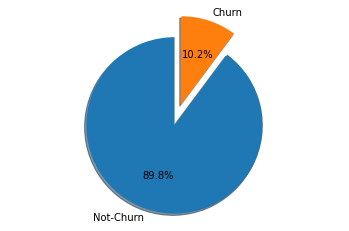

In [6]:
plt.figure(figsize=(15,12))
fig1, ax1 = plt.subplots() 
labels = ['Not-Churn','Churn']
ax1.pie(churn_train["churn_probability"].value_counts(),explode=[0,0.25], labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

- Data is highly imbalanced, we need to balance it while creating the model

<AxesSubplot:xlabel='aon'>

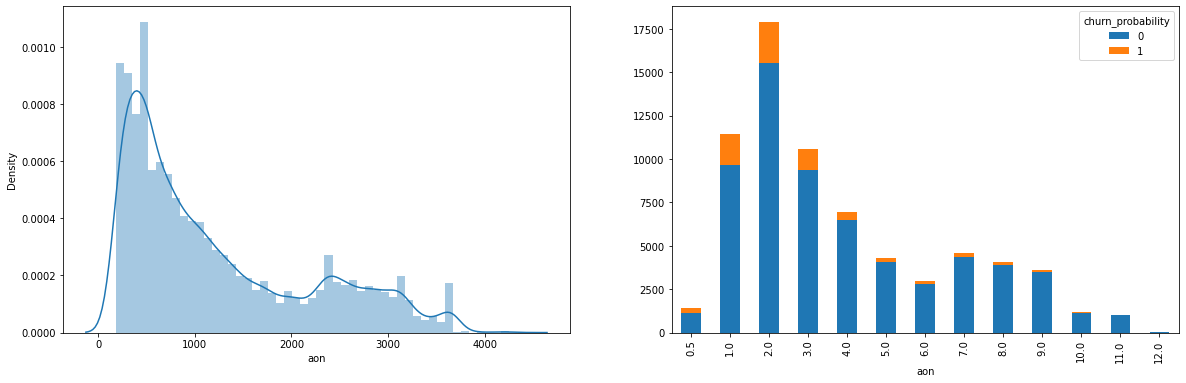

In [7]:
# Age on Network
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20, 6))

# distribution plot for aon
sns.distplot(churn_train['aon'], ax=ax1)

# bin the aon column with yearwise segments and plot the counts for each segments
bins = [0, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
labels = [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
pd.crosstab(pd.cut(round(((churn_train['aon']/30)/12),1), bins = bins, labels = labels ), churn_train['churn_probability']).plot(kind='bar', stacked=True, ax = ax2)

- We could see more number of observations between 1 and 3 years
- Also churn rate is high during this range than the others

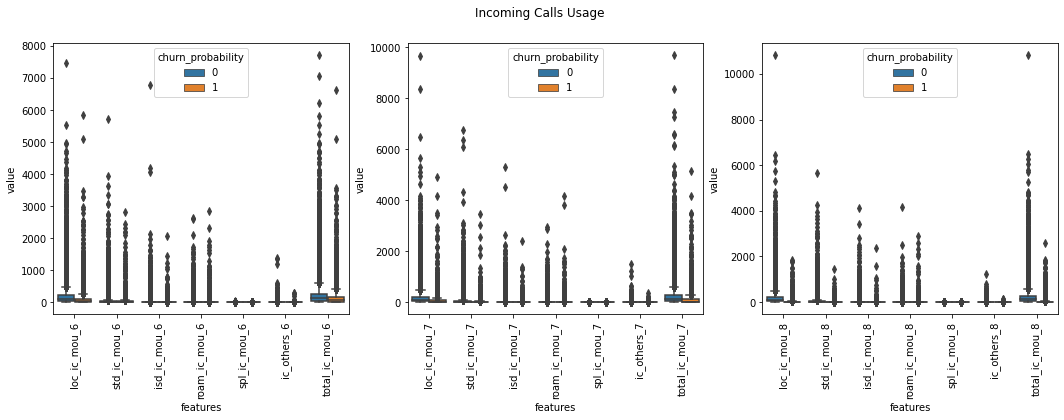

In [8]:
# Incoming calls usage

cols = [['loc_ic_mou_6','std_ic_mou_6','isd_ic_mou_6','roam_ic_mou_6','spl_ic_mou_6','ic_others_6','total_ic_mou_6'],
        ['loc_ic_mou_7','std_ic_mou_7','isd_ic_mou_7','roam_ic_mou_7','spl_ic_mou_7','ic_others_7','total_ic_mou_7'],
        ['loc_ic_mou_8','std_ic_mou_8','isd_ic_mou_8','roam_ic_mou_8','spl_ic_mou_8','ic_others_8','total_ic_mou_8']]

# plot for the incoming calls usage
plt.figure(figsize=(18, 5))
for i in range(0,3):
    plt.subplot(1,3,i+1)
    X = pd.concat([churn_train[cols[i]], churn_train['churn_probability']], axis=1)
    X = pd.melt(X,id_vars="churn_probability",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn_probability", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Incoming Calls Usage')

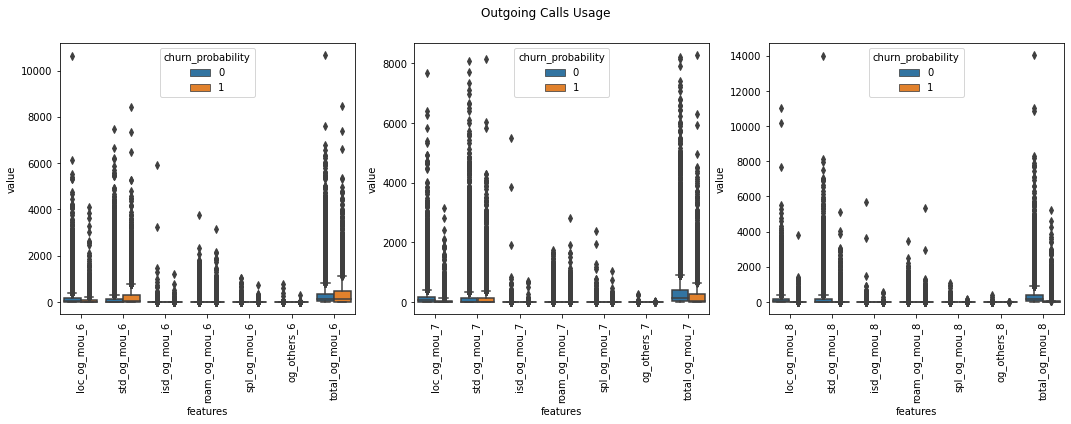

In [9]:
# Outgoing calls usage

cols = [['loc_og_mou_6','std_og_mou_6','isd_og_mou_6','roam_og_mou_6','spl_og_mou_6','og_others_6','total_og_mou_6'],
        ['loc_og_mou_7','std_og_mou_7','isd_og_mou_7','roam_og_mou_7','spl_og_mou_7','og_others_7','total_og_mou_7'],
        ['loc_og_mou_8','std_og_mou_8','isd_og_mou_8','roam_og_mou_8','spl_og_mou_8','og_others_8','total_og_mou_8']]

# plot for the outgoing calls usage
plt.figure(figsize=(18, 5))
#ic call usage
for i in range(0,3):
    plt.subplot(1,3,i+1)
    X = pd.concat([churn_train[cols[i]], churn_train['churn_probability']], axis=1)
    X = pd.melt(X,id_vars="churn_probability",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn_probability", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Outgoing Calls Usage')

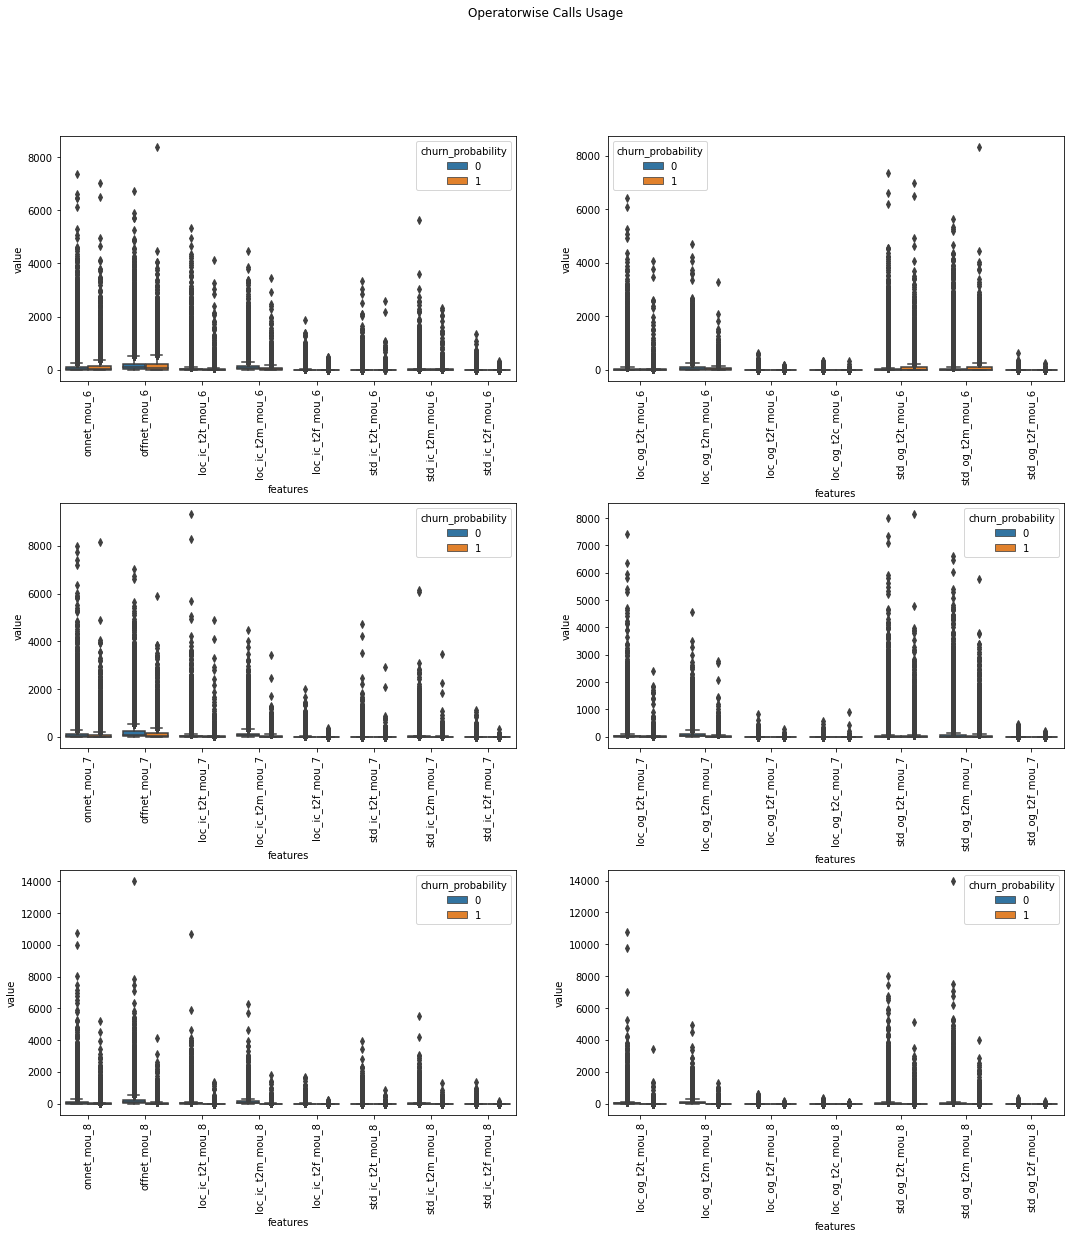

In [10]:
# Operator wise usage

cols = [['onnet_mou_6','offnet_mou_6','loc_ic_t2t_mou_6','loc_ic_t2m_mou_6','loc_ic_t2f_mou_6','std_ic_t2t_mou_6','std_ic_t2m_mou_6','std_ic_t2f_mou_6'],
        ['loc_og_t2t_mou_6','loc_og_t2m_mou_6','loc_og_t2f_mou_6','loc_og_t2c_mou_6','std_og_t2t_mou_6','std_og_t2m_mou_6','std_og_t2f_mou_6'],
        ['onnet_mou_7','offnet_mou_7','loc_ic_t2t_mou_7','loc_ic_t2m_mou_7','loc_ic_t2f_mou_7','std_ic_t2t_mou_7','std_ic_t2m_mou_7','std_ic_t2f_mou_7'],
        ['loc_og_t2t_mou_7','loc_og_t2m_mou_7','loc_og_t2f_mou_7','loc_og_t2c_mou_7','std_og_t2t_mou_7','std_og_t2m_mou_7','std_og_t2f_mou_7'],
        ['onnet_mou_8','offnet_mou_8','loc_ic_t2t_mou_8','loc_ic_t2m_mou_8','loc_ic_t2f_mou_8','std_ic_t2t_mou_8','std_ic_t2m_mou_8','std_ic_t2f_mou_8'],
        ['loc_og_t2t_mou_8','loc_og_t2m_mou_8','loc_og_t2f_mou_8','loc_og_t2c_mou_8','std_og_t2t_mou_8','std_og_t2m_mou_8','std_og_t2f_mou_8']]

# plot for the operatorwise calls usage
plt.figure(figsize=(18, 18))
plt.subplots_adjust(hspace=0.5)
for i in range(0,6):
    plt.subplot(3,2,i+1)
    X = pd.concat([churn_train[cols[i]], churn_train['churn_probability']], axis=1)
    X = pd.melt(X,id_vars="churn_probability",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn_probability", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Operatorwise Calls Usage')

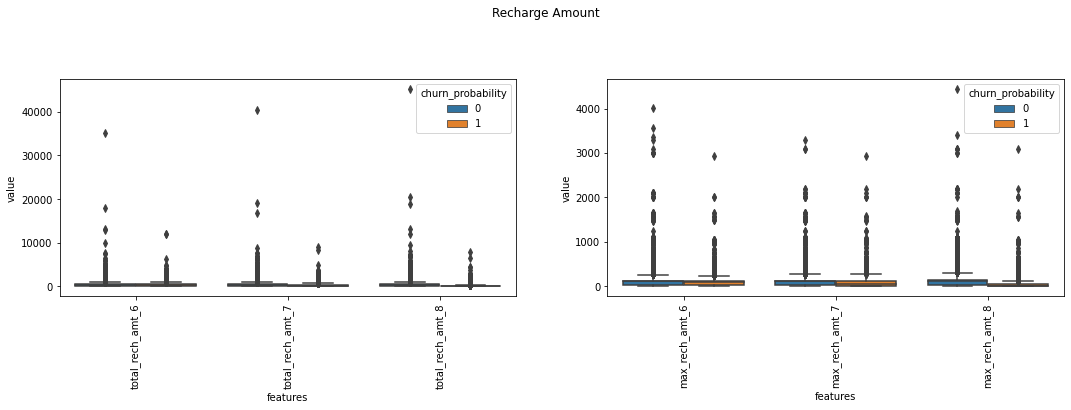

In [11]:
# Recharge amount
cols = [
        ['total_rech_amt_6','total_rech_amt_7','total_rech_amt_8'],
        ['max_rech_amt_6','max_rech_amt_7','max_rech_amt_8']
       ]

# plot for the recharge amount columns
plt.figure(figsize=(18, 10))
plt.subplots_adjust(hspace=0.5)
for i in range(0,2):
    plt.subplot(2,2,i+1)
    X = pd.concat([churn_train[cols[i]], churn_train['churn_probability']], axis=1)
    X = pd.melt(X,id_vars="churn_probability",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn_probability", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Recharge Amount')

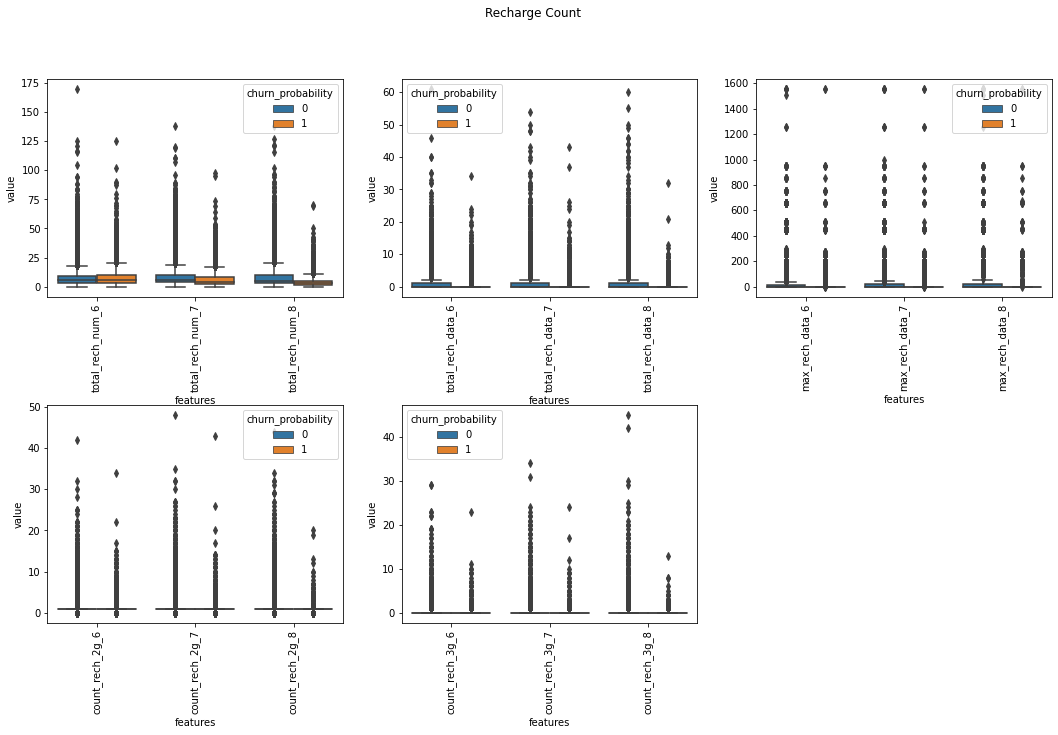

In [12]:
# Recharge count

cols = [
        ['total_rech_num_6','total_rech_num_7','total_rech_num_8'],
        ['total_rech_data_6','total_rech_data_7','total_rech_data_8'],
        ['max_rech_data_6','max_rech_data_7','max_rech_data_8'],
        ['count_rech_2g_6','count_rech_2g_7','count_rech_2g_8'],
        ['count_rech_3g_6','count_rech_3g_7','count_rech_3g_8'] 
       ]

# plot for the recharge count columns
plt.figure(figsize=(18, 10))
plt.subplots_adjust(hspace=0.5)
for i in range(0,5):
    plt.subplot(2,3,i+1)
    X = pd.concat([churn_train[cols[i]], churn_train['churn_probability']], axis=1)
    X = pd.melt(X,id_vars="churn_probability",var_name="features",value_name='value')
    sns.boxplot(x="features", y="value", hue="churn_probability", data=X)
    plt.xticks(rotation=90)    
    plt.suptitle('Recharge Count')

<AxesSubplot:>

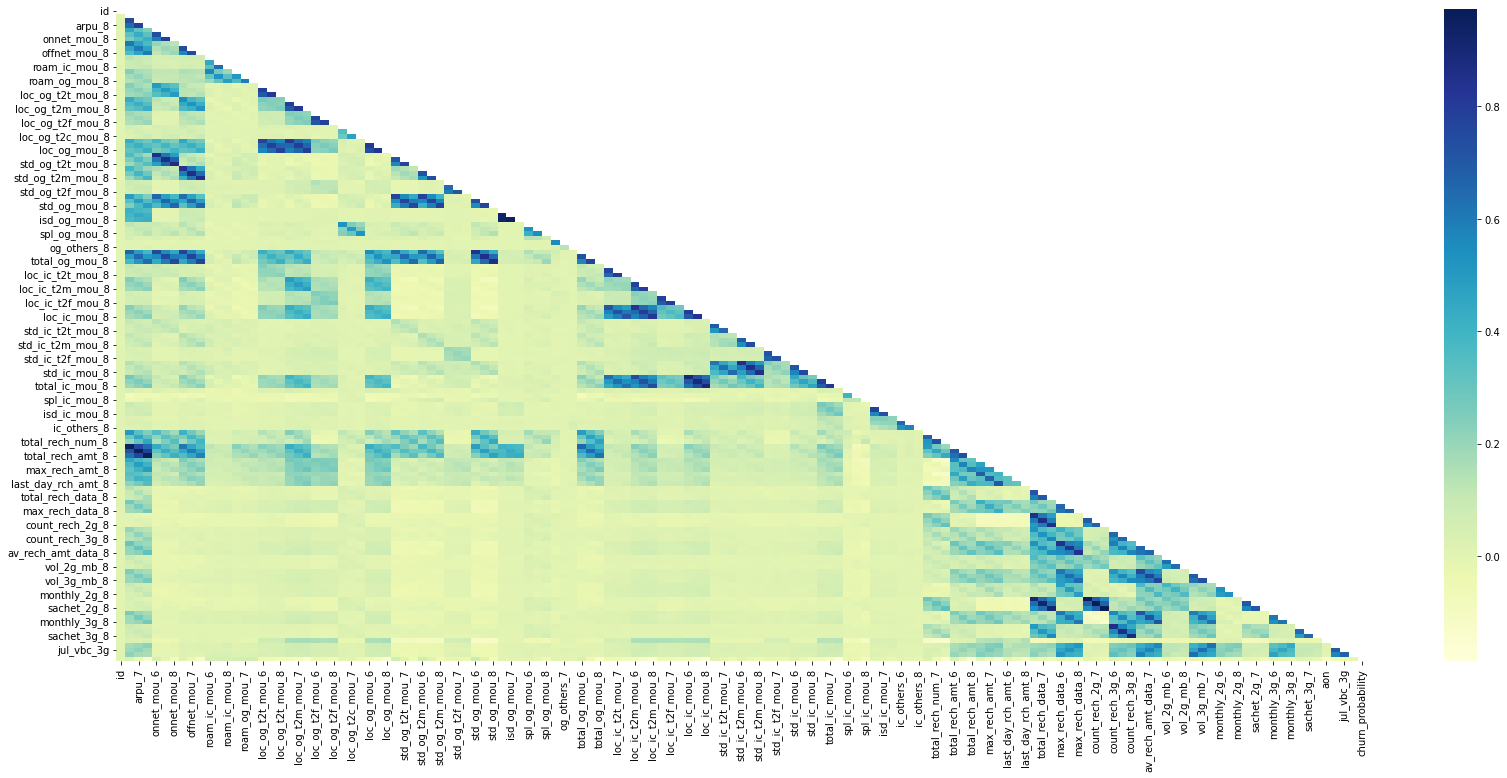

In [13]:
import seaborn as sns

plt.figure(figsize=(28,12))
sns.heatmap(churn_train.corr(),cmap="YlGnBu",annot=False,mask=np.triu(churn_train.corr()))

- For Top percentiles we can observe outliers.
- We can see there are columns which are highly correlated 

**From business analysis month 6 and 7 are good phase, Where as month 8th in churn phase .Lets' verify this --**

In [14]:
avg_good_phase=(churn_train.total_rech_amt_6+churn_train.total_rech_amt_7)/2

In [15]:
less_recharge=churn_train[churn_train.total_rech_amt_8 < avg_good_phase]

In [16]:
(less_recharge.churn_probability==1).sum()/(less_recharge.churn_probability==0).sum()

0.19161233953894752

In [17]:
more_recharge=churn_train[churn_train.total_rech_amt_8 >= avg_good_phase]

In [18]:
(more_recharge.churn_probability==1).sum()/(more_recharge.churn_probability==0).sum()

0.04319067323084358

- We can observe that those who recharge more amount in 8th comparison to 6th and 7th are less likely to churn out

## Data Preparation

In [19]:
X = churn_train[churn_train.columns[~churn_train.columns.isin(['churn_probability'])]]
Y = churn_train['churn_probability']

In [20]:
#Scaling
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [21]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_std,Y, train_size=0.7,test_size=0.3,random_state=42)

In [22]:
print("Training dataset size",X_train.shape)
print("Training dataset target size",y_train.shape)
print("Test dataset size",X_test.shape)
print("Test dataset target size",y_test.shape)

Training dataset size (48999, 140)
Training dataset target size (48999,)
Test dataset size (21000, 140)
Test dataset target size (21000,)


In [23]:
print("Data imbalance, counts of label '1': {}".format(sum(y_train==1)))
print("Data imbalance, counts of label '0': {} \n".format(sum(y_train==0)))

Data imbalance, counts of label '1': 4977
Data imbalance, counts of label '0': 44022 



## PCA

In [24]:
#Import PCA
from sklearn.decomposition import PCA

# Instantiate PCA
pca = PCA(random_state=42)

In [25]:
# Fit train set on PCA
pca.fit(X_train)

PCA(random_state=42)

In [26]:
# Principal components
pca.components_

array([[ 1.33592414e-03,  1.73647817e-01,  1.79792822e-01, ...,
         7.24926541e-02,  7.05938201e-02,  6.72074508e-02],
       [ 1.22949301e-03, -1.70278844e-02, -2.05369512e-02, ...,
         1.50139606e-01,  1.51283640e-01,  1.46171943e-01],
       [ 2.39871619e-03, -5.20323096e-02, -6.66081030e-02, ...,
        -1.91507536e-02, -1.92625316e-02, -1.75959545e-02],
       ...,
       [ 0.00000000e+00, -2.32256335e-16,  2.58955729e-16, ...,
         5.74197098e-17,  1.13094243e-17, -2.13744699e-17],
       [-0.00000000e+00,  2.57079686e-16, -7.21082537e-17, ...,
        -3.19256318e-19,  1.30199718e-16, -4.97326251e-17],
       [ 0.00000000e+00, -1.64639063e-16,  1.59926673e-16, ...,
        -3.56332035e-17,  1.61368688e-18,  7.51556339e-18]])

Text(0, 0.5, 'Cumulative Variance')

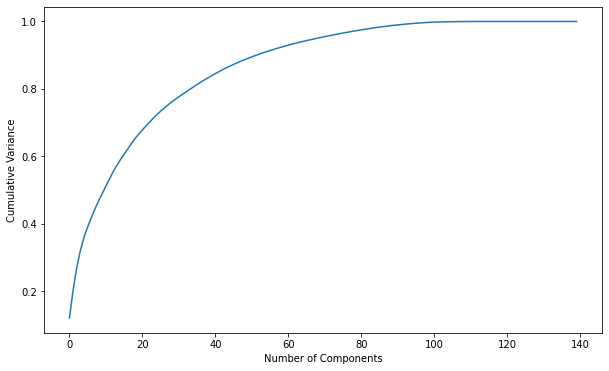

In [27]:
# plot feature variance with scree plot
variance_cumu = np.cumsum(pca.explained_variance_ratio_)
fig = plt.figure(figsize = (10,6))
plt.plot(variance_cumu)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')

*We can see that 70 components explain amost more than 85% variance of the data. So, we will perform PCA with 60 components.*

#### Performing PCA with 70 components

In [28]:
#pick the number of components explaining max variance
pca_X= PCA(n_components=70)

df_train_pca_X = pca_X.fit_transform(X_train)
print(df_train_pca_X.shape)
df_test_pca_X = pca_X.transform(X_test)
print(df_test_pca_X.shape)

(48999, 70)
(21000, 70)


## Logistic Regression with PCA

In [29]:
#Run the model using the selected variables
LR = LogisticRegression(class_weight='balanced')
LR.fit(df_train_pca_X, y_train)

LogisticRegression(class_weight='balanced')

In [30]:
#Predicted probabilities
y_pred_train = LR.predict(df_train_pca_X)

#Printing results
print("Train data results")
print('*'*80, '\n');
lr_train_acc = accuracy_score(y_train,y_pred_train)
print("Accuracy Score:",lr_train_acc)
print('*'*80, '\n');
print("Classification Report:")
print(classification_report(y_train, y_pred_train))
print('*'*80, '\n');
print("Confusion Matrix:")
print(confusion_matrix(y_train,y_pred_train))
print('*'*80, '\n');
print("roc_auc_score: {:2.2}".format(metrics.roc_auc_score(y_train, y_pred_train)))

Train data results
******************************************************************************** 

Accuracy Score: 0.7841996775444396
******************************************************************************** 

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.78      0.87     44022
           1       0.30      0.85      0.45      4977

    accuracy                           0.78     48999
   macro avg       0.64      0.81      0.66     48999
weighted avg       0.91      0.78      0.82     48999

******************************************************************************** 

Confusion Matrix:
[[34182  9840]
 [  734  4243]]
******************************************************************************** 

roc_auc_score: 0.81


In [31]:
#Predicted probabilities
y_pred_test = LR.predict(df_test_pca_X)

#Printing results
print("Test data results");
print('*'*80, '\n');
lr_test_acc = accuracy_score(y_test,y_pred_test)
print("Accuracy Score:",lr_test_acc )
print('*'*80, '\n');
print("Classification Report:")
print(classification_report(y_test, y_pred_test))
print('*'*80, '\n');
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred_test))
print('*'*80, '\n');
print("roc_auc_score: {:2.2}".format(metrics.roc_auc_score(y_test, y_pred_test)))
lr_precission=precision_score(y_test, y_pred_test)
lr_recall=recall_score(y_test, y_pred_test)

Test data results
******************************************************************************** 

Accuracy Score: 0.7853333333333333
******************************************************************************** 

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.78      0.87     18845
           1       0.31      0.87      0.45      2155

    accuracy                           0.79     21000
   macro avg       0.64      0.82      0.66     21000
weighted avg       0.91      0.79      0.82     21000

******************************************************************************** 

Confusion Matrix:
[[14611  4234]
 [  274  1881]]
******************************************************************************** 

roc_auc_score: 0.82


## Random Forest with Default parameters

In [32]:
#Running the random forest with default parameters.
rfc = RandomForestClassifier(class_weight = "balanced", random_state=42)

#fit
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [33]:
predictions_train = rfc.predict(X_train)
print ("Train data results")
print('*'*80, '\n');
rfc_train_acc = accuracy_score(y_train, predictions_train)
print("Accuracy Score:", rfc_train_acc)
print('*'*80, '\n');
print("Classification Report:")
print(classification_report(y_train, predictions_train))
print('*'*80, '\n');
print("Confusion Matrix:")
print(confusion_matrix(y_train, predictions_train))

Train data results
******************************************************************************** 

Accuracy Score: 0.9999795914202331
******************************************************************************** 

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     44022
           1       1.00      1.00      1.00      4977

    accuracy                           1.00     48999
   macro avg       1.00      1.00      1.00     48999
weighted avg       1.00      1.00      1.00     48999

******************************************************************************** 

Confusion Matrix:
[[44022     0]
 [    1  4976]]


In [34]:
print ("Test data results")
print('*'*80, '\n');
rfc_predictions_test = rfc.predict(X_test)
rfc_test_acc = accuracy_score(y_test, rfc_predictions_test)
print("Accuracy Score:", rfc_test_acc)
print('*'*80, '\n');
print("Classification Report:")
print(classification_report(y_test, rfc_predictions_test))
print('*'*80, '\n');
print("Confusion Matrix:")
print(confusion_matrix(y_test, rfc_predictions_test))
rfc_precission=precision_score(y_test, rfc_predictions_test)
rfc_recall=recall_score(y_test, rfc_predictions_test)

Test data results
******************************************************************************** 

Accuracy Score: 0.9402857142857143
******************************************************************************** 

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     18845
           1       0.79      0.58      0.66      2155

    accuracy                           0.94     21000
   macro avg       0.87      0.78      0.82     21000
weighted avg       0.94      0.94      0.94     21000

******************************************************************************** 

Confusion Matrix:
[[18506   339]
 [  915  1240]]


## Random Forest with Hyperparamter tunning

In [35]:
# # model with the best hyperparameters
# using class weights to handle imbalance

count_class_1 = y_train.value_counts()[0]
count_class_2 = y_train.value_counts()[1]
ratio = count_class_1/count_class_2

# random forest - the class weight is used to handle class imbalance - it adjusts the cost function
random_forest = RandomForestClassifier(class_weight={1:ratio, 0:1}, 
                                       n_jobs = -1,
                                       min_samples_leaf=100, 
                                       min_samples_split=200,
                                       n_estimators=100)

# hyperparameter space
params = {"criterion": ['gini', 'entropy'], "max_features": ['auto', 0.4]}

# create 3 folds
folds = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 4)

# create gridsearch object
rf_model = GridSearchCV(estimator=random_forest, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [36]:
# fit model
rf_model.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=4, shuffle=True),
             estimator=RandomForestClassifier(class_weight={0: 1,
                                                            1: 8.845087402049428},
                                              min_samples_leaf=100,
                                              min_samples_split=200,
                                              n_jobs=-1),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 0.4]},
             scoring='roc_auc', verbose=1)

In [37]:
# print best hyperparameters
print("Best AUC: ", rf_model.best_score_)
print("Best hyperparameters: ", rf_model.best_params_)

Best AUC:  0.9379343494453661
Best hyperparameters:  {'criterion': 'entropy', 'max_features': 0.4}


In [38]:
predictions_train = rf_model.predict(X_train)
print ("Train data results")
print('*'*80, '\n');
rf_model_train_acc = accuracy_score(y_train, predictions_train)
print("Accuracy Score:", rf_model_train_acc)
print('*'*80, '\n');
print("Classification Report:")
print(classification_report(y_train, predictions_train))
print('*'*80, '\n');
print("Confusion Matrix:")
print(confusion_matrix(y_train, predictions_train))

Train data results
******************************************************************************** 

Accuracy Score: 0.9133451703095982
******************************************************************************** 

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95     44022
           1       0.55      0.86      0.67      4977

    accuracy                           0.91     48999
   macro avg       0.76      0.89      0.81     48999
weighted avg       0.94      0.91      0.92     48999

******************************************************************************** 

Confusion Matrix:
[[40479  3543]
 [  703  4274]]


In [39]:
print ("Test data results")
print('*'*80, '\n');
rf_model_predictions_test = rf_model.predict(X_test)
rf_model_test_acc = accuracy_score(y_test, rf_model_predictions_test)
print("Accuracy Score:", rf_model_test_acc)
print('*'*80, '\n');
print("Classification Report:")
print(classification_report(y_test, rf_model_predictions_test))
print('*'*80, '\n');
print("Confusion Matrix:")
print(confusion_matrix(y_test, rf_model_predictions_test))
rf_model_precission=precision_score(y_test, rf_model_predictions_test)
rf_model_recall=recall_score(y_test, rf_model_predictions_test)

Test data results
******************************************************************************** 

Accuracy Score: 0.9080952380952381
******************************************************************************** 

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95     18845
           1       0.53      0.83      0.65      2155

    accuracy                           0.91     21000
   macro avg       0.76      0.88      0.80     21000
weighted avg       0.93      0.91      0.92     21000

******************************************************************************** 

Confusion Matrix:
[[17271  1574]
 [  356  1799]]


## XGBoost 

In [40]:
X_train.shape

(48999, 140)

In [41]:
from xgboost import XGBClassifier

#Running the random forest with default parameters and using rfe
xgb = XGBClassifier(random_state=42)
#fit
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [42]:
predictions_train = xgb.predict(X_train)
print ("Train data results")
print('*'*80, '\n');
xgb_train_acc = accuracy_score(y_train, predictions_train)
print("accuracy score:", xgb_train_acc)
print('*'*80, '\n');
print("classification report:")
print(classification_report(y_train, predictions_train))
print('*'*80, '\n');
print("confusion matrix:")
print(confusion_matrix(y_train, predictions_train))

Train data results
******************************************************************************** 

accuracy score: 0.9779383252719444
******************************************************************************** 

classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     44022
           1       0.91      0.86      0.89      4977

    accuracy                           0.98     48999
   macro avg       0.95      0.93      0.94     48999
weighted avg       0.98      0.98      0.98     48999

******************************************************************************** 

confusion matrix:
[[43618   404]
 [  677  4300]]


In [43]:
print ("Test data results")
print('*'*80, '\n');
xgb_predictions_test = xgb.predict(X_test)
xgb_test_acc = accuracy_score(y_test, xgb_predictions_test)
print("accuracy score:", xgb_test_acc)
print('*'*80, '\n');
print("classification report:")
print(classification_report(y_test, xgb_predictions_test))
print('*'*80, '\n');
print("confusion matrix:")
print(confusion_matrix(y_test, xgb_predictions_test))
xgb_precission=precision_score(y_test, xgb_predictions_test)
xgb_recall=recall_score(y_test, xgb_predictions_test)

Test data results
******************************************************************************** 

accuracy score: 0.9402857142857143
******************************************************************************** 

classification report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     18845
           1       0.74      0.64      0.69      2155

    accuracy                           0.94     21000
   macro avg       0.85      0.81      0.83     21000
weighted avg       0.94      0.94      0.94     21000

******************************************************************************** 

confusion matrix:
[[18374   471]
 [  783  1372]]


In [44]:
importances = xgb.feature_importances_
col_names =  X.columns

RF_feature_importance = pd.DataFrame(sorted(zip(importances, list(col_names)), reverse=True),columns={'colName','value'})
RF_feature_importance.head(15)

,colName,value
0,0.204850,total_ic_mou_8
1,0.081681,loc_ic_mou_8
2,0.081294,total_rech_data_8
3,0.023444,roam_og_mou_8
4,0.017483,last_day_rch_amt_8
5,0.015187,spl_ic_mou_8
6,0.013041,av_rech_amt_data_8
7,0.010484,offnet_mou_8
8,0.010386,std_og_mou_7
9,0.009886,total_rech_amt_8


In [45]:
results = {'Algorithm':['LR With PCA', 'Random Forest with Default Parameter','Random Forest with Hyper-Parameter','XGBoost'],
        'Train Accuracy':[lr_train_acc, rfc_train_acc, rf_model_train_acc,xgb_train_acc],
        'Test Accuracy':[lr_test_acc, rfc_test_acc, rf_model_test_acc,xgb_test_acc],
        'Precission':[lr_precission, rfc_precission, rf_model_precission,xgb_precission],
        'Recall':[lr_recall, rfc_recall, rf_model_recall,xgb_recall],
       }
  
results_df = pd.DataFrame(results)
results_df.set_index('Algorithm')

,Train Accuracy,Test Accuracy,Precission,Recall
Algorithm,,,,
LR With PCA,0.784200,0.785333,0.307604,0.872854
Random Forest with Default Parameter,0.999980,0.940286,0.785307,0.575406
Random Forest with Hyper-Parameter,0.913345,0.908095,0.533353,0.834803
XGBoost,0.977938,0.940286,0.744438,0.636659


## Evaluating Test Data

In [46]:
churn_test = pd.read_csv("test.csv")
churn_test = data_imputation(churn_test)

Initial Missing value :-
 id                           0.00
circle_id                    0.00
loc_og_t2o_mou               1.05
std_og_t2o_mou               1.05
loc_ic_t2o_mou               1.05
last_date_of_month_6         0.00
last_date_of_month_7         0.67
last_date_of_month_8         1.22
arpu_6                       0.00
arpu_7                       0.00
arpu_8                       0.00
onnet_mou_6                  3.90
onnet_mou_7                  3.91
onnet_mou_8                  5.58
offnet_mou_6                 3.90
offnet_mou_7                 3.91
offnet_mou_8                 5.58
roam_ic_mou_6                3.90
roam_ic_mou_7                3.91
roam_ic_mou_8                5.58
roam_og_mou_6                3.90
roam_og_mou_7                3.91
roam_og_mou_8                5.58
loc_og_t2t_mou_6             3.90
loc_og_t2t_mou_7             3.91
loc_og_t2t_mou_8             5.58
loc_og_t2m_mou_6             3.90
loc_og_t2m_mou_7             3.91
loc_og_t2m_mou_8      

In [47]:
print('Dataframe Shape: ', churn_test.shape); 
churn_test.head(5)

solution_orig=pd.read_csv("solution.csv")

Y_actual=solution_orig.churn_probability

Dataframe Shape:  (30000, 140)


In [48]:
solution_df = churn_test[['id']].copy()
test_data = scaler.fit_transform(churn_test)

predictions_test = rf_model.predict(test_data)

predictions_test

count_arr = np.bincount(predictions_test)
# Count occurrence of element '1' in numpy array
print('Total occurences of "1" in array: ', count_arr[1])
# Count occurrence of element '0' in numpy array
print('Total occurences of "0" in array: ', count_arr[0])

predictions_test.shape

solution_df.insert(loc=1, column='churn_probability', value=predictions_test)

solution_df.head(10)

solution_df.to_csv('submission.csv', index=False)

Total occurences of "1" in array:  3253
Total occurences of "0" in array:  26747


### On kaggle evaluation data, best accuracy observed with Random Forest with hyper-parameter tunning 

**Important Features observed for model predicting are as follows**

In [49]:
#to understand important features we can use XGBoost model
importances = xgb.feature_importances_
col_names =  X.columns

RF_feature_importance = pd.DataFrame(sorted(zip(importances, list(col_names)), reverse=True),columns=['colName','value'])
RF_feature_importance.head(15)

,colName,value
0,0.204850,total_ic_mou_8
1,0.081681,loc_ic_mou_8
2,0.081294,total_rech_data_8
3,0.023444,roam_og_mou_8
4,0.017483,last_day_rch_amt_8
5,0.015187,spl_ic_mou_8
6,0.013041,av_rech_amt_data_8
7,0.010484,offnet_mou_8
8,0.010386,std_og_mou_7
9,0.009886,total_rech_amt_8


**Conclusions**
- 8th month parameters are important
- aon -> Age on network number of days the customer is using the network is very important
- high_value_customer_diff -> As expected derived feature high_value_customer_diff impacts the churn behavior. This mean if total recharge is decreasing month on , those customer are highly likely to churn